![montage](../images/montage_mri_final.png)

## Quantitative T1 MRI using Python

## Model: $$ S = Mz * (1 - e^{ (TR / T1 )} )$$

## Objetive: 
- Estimate `T1` and `Mz` for all voxels in the data


## Metadata
- TR (msec) =  508.2336 1000 1500 2500 3500 4500 5500 6500
- Rows = 128
- Cols = 128
- Total images = 168
- Slices = 21  

## Sample:
- Lime

## source:
- Data.World ([@julio](https://data.world/julio/learn-quantitative-mri))




In [1]:
# Modules
import pandas as pd
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

In [3]:
# define variables
TR = [508.2336 ,1000 ,1500 ,2500 ,3500 ,4500 ,5500 ,6500];
TR = np.array(TR)/1000;
Total_Slices = 21

# load data
cut_trough_lime = 10;
#matrix
MRI_2D = pd.read_csv('../data/T1Lemon.csv',header=None).values[:,1::];

In [4]:
# model
def t1_time(x_,*pars):
    return pars[0] * (1 - np.exp(-x_ / pars[1]))

# fittign function
def fit_t1_time(signal):
    signal = signal / np.max(signal)
    #fit
    fitted_pars, cov= curve_fit(t1_time, TR, signal, p0 = [1. , 2], maxfev = 1000)
    return fitted_pars[1]

# mapping function
def T1map(DataMatrix, Slice = 1):
    # extract sllices
    I = DataMatrix [:, Slice:168:21]
    # number of voxels
    voxels, _ = I.shape
    # preallocate
    T1 = np.zeros((voxels,1))
    # Loop function
    for idx, signal in enumerate(I):
        T1[idx] = fit_t1_time(signal)
            
    return T1.reshape((128,128))

### Signal evolution

![T1](./T1_evolution.png)

# Process all 16384 voxels

In [5]:
%%time
map_T1 = T1map(MRI_2D, 1)

/Users/Julio/anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/Julio/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


CPU times: user 12 s, sys: 40.6 ms, total: 12 s
Wall time: 12 s


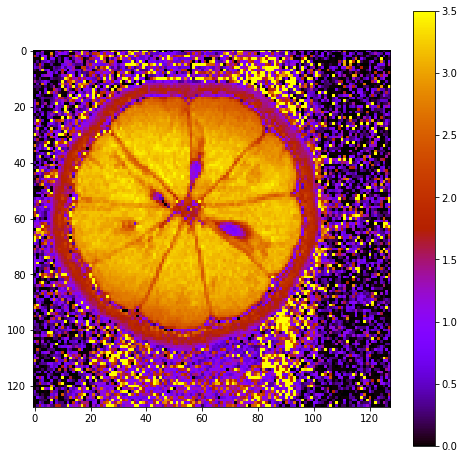

In [6]:
plt.figure(figsize = (8,8));
plt.imshow(map_T1, cmap ='gnuplot', vmin = 0, vmax= 3.5); plt.colorbar();

# Process  6789 voxels with SNR > 20

In [7]:
# mapping function
def T1map_V2(DataMatrix, Slice):
    # extract sllices
    I = DataMatrix [:, Slice:168:21]
    
    # number of voxels
    voxels, _ = I.shape

    # create filter
    SNR = I[:,0] / np.std(DataMatrix[0,:])

    # preallocate
    T1 = np.zeros_like(SNR)
    T1[SNR <20] = 0
    
    # map function
    predicted_T1 = map(fit_t1_time, list(I[SNR > 20, :]))
    predicted_T1 = np.array( list(predicted_T1) )
    
    # output
    T1[SNR > 20] = predicted_T1
    
    return T1.reshape((128,128))

In [8]:
%%time
map_T1 = T1map_V2(MRI_2D, 1);

/Users/Julio/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/Users/Julio/anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


CPU times: user 4.08 s, sys: 15.5 ms, total: 4.1 s
Wall time: 4.1 s


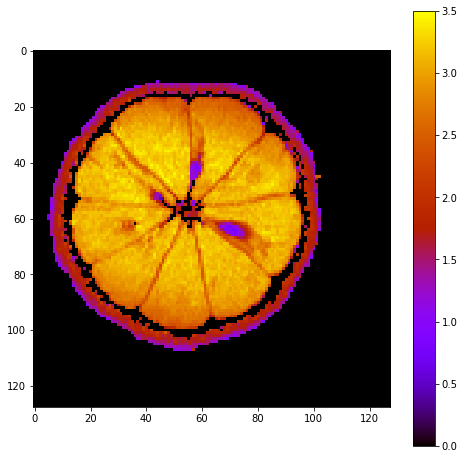

In [9]:
plt.figure(figsize = (8,8));
plt.imshow(map_T1, cmap ='gnuplot', vmin = 0, vmax= 3.5); plt.colorbar();